# Encoding and Decoding with  ConvMP on 1 Layer

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import torch
from CHAMP.CHAMP_Layer import CHAMP_Layer
from CHAMP.DataLoader import LoadData
from CHAMP.DataTools import LocalContrastNormalization, FilterInputData, GenerateMask
from CHAMP.Monitor import DisplayDico, DisplayConvergenceCHAMP, DisplayWhere
from CHAMP.DataTools import Rebuilt
# inform on the location of your dataset
#datapath = "../../../Science/These/Rapport d'avancement/database/"
import os
home = os.getenv('HOME')
from CHAMP.DataTools import SaveNetwork, LoadNetwork
datapath = os.path.join(home, "science/VB_These/Rapport d'avancement/database")

## Loading the Face DataBase

In [2]:
path = os.path.join(datapath, "Face_DataBase")

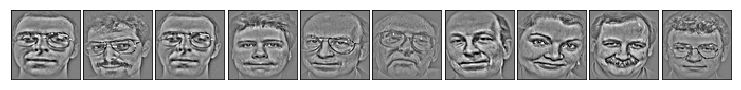

In [3]:
TrSet, TeSet = LoadData('Face', path, decorrelate=False, resize=(65, 65))
N_TrSet, _, _, _ = LocalContrastNormalization(TrSet)
Filtered_L_TrSet = FilterInputData(
    N_TrSet, sigma=0.25, style='Custom', start_R=15)
to_display = Filtered_L_TrSet[0][0, 0:10, :, :, :]
DisplayDico(to_display)

## Training the ConvMP_Layer

In [4]:
# MP Parameters
nb_dico = 8
width = 13
dico_size = (width, width)
l0 = 30
seed = 30
# Learning Parameters
eta = .05
nb_epoch = 200
mask = GenerateMask(full_size=(nb_dico, 1, width, width), sigma=0.8, style='Gaussian')

In [5]:
L1_mask = CHAMP_Layer(l0_sparseness=l0, nb_dico=nb_dico,
                      dico_size=dico_size, mask=mask, verbose=2)
dico_mask = L1_mask.TrainLayer(
    Filtered_L_TrSet, eta=eta, nb_epoch=nb_epoch, seed=seed)

epoch 1 - 100 done in 2m51s
epoch 100 - 200 done in 2m48s


## Saving The Model in a file

In [6]:
SaveNetwork(Network=L1_mask,saving_path='SaveExample.pkl')

file saved


## Loading The Model from a file

In [7]:
L1_mask = LoadNetwork(loading_path='SaveExample.pkl')

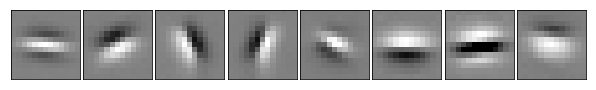

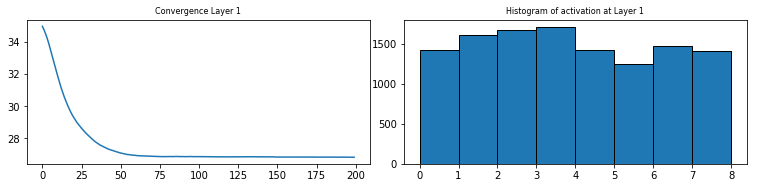

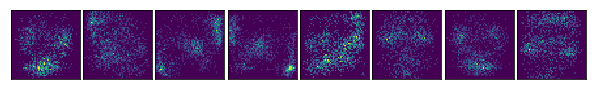

In [8]:
DisplayDico(L1_mask.dictionary)
DisplayConvergenceCHAMP(L1_mask, to_display=['error', 'histo'])
DisplayWhere(L1_mask.where)

## Representation of the feature map (encoding)

We represent here the 8 features maps (one per dictionary) resulting from the encoding process of the first image

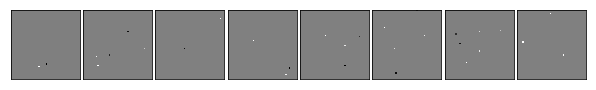

In [9]:
#print(L1_mask.code.shape)
#print(L1_mask.nb_dico)
DisplayDico(L1_mask.code[0,:,:,:].reshape(8,1,53,53))

## Reconstructing the input image

In [10]:
rebuilt_image = Rebuilt(torch.FloatTensor(L1_mask.code),L1_mask.dictionary)

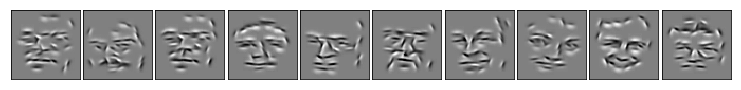

In [11]:
DisplayDico(rebuilt_image[0:10,:,:,:])

## Reconstruted image per layer

The function rebuilt could output the Layer-wise reconstruction provided that the 'groups' value is equal to the number of dictionary.

In [12]:
rebuilt_per_layer = Rebuilt(torch.FloatTensor(L1_mask.code),L1_mask.dictionary,groups=nb_dico)

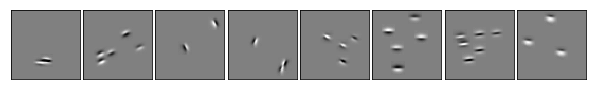

In [13]:
DisplayDico(rebuilt_per_layer[0,:,:,:].view(nb_dico,1,65,65))